In [242]:
!pip install statsmodels

Nxt
N = number of nodes in parcellation
t = number of timepoints
A = NxN
Pearson’s correlation

A_ij = Pearson’s correlation between timeseries I and j each of length t
(You can also fisher’s z transform)

Should need just the time series

Following: https://nilearn.github.io/dev/auto_examples/00_tutorials/plot_decoding_tutorial.html#sphx-glr-auto-examples-00-tutorials-plot-decoding-tutorial-py

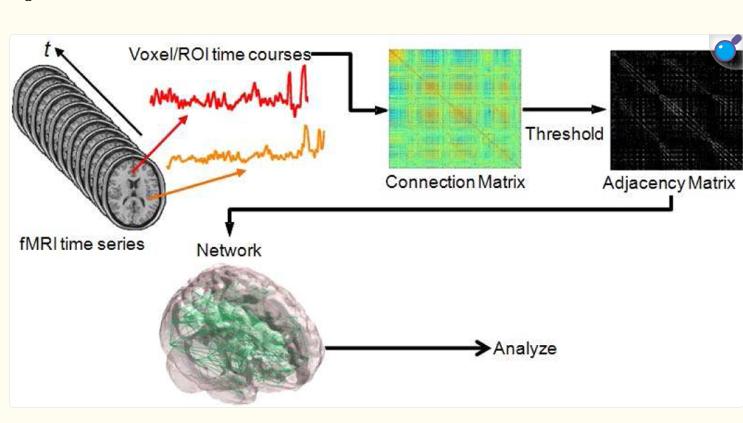

In [243]:
import numpy as np
import networkx as nx
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

# Helper Functions

__Brain Net Viewer Output__

The node file is defined as an ASCII text file with the suffix ‘node’. In the node file, there are 6 columns:
columns 1-3 represent node coordinates, column 4 represents node colors, column 5 represents node
10
BrainNet Viewer User Manual 1.61, October, 2017
sizes, and the last column represents node labels.

In [244]:
import pandas as pd
from community import community_louvain # https://python-louvain.readthedocs.io/en/latest/api.html
def output_brain_net_viewer(node_data, G, coords, output_node_name, output_edge_name, weighted=False):
    '''
    Formats data for Brain Net Viewer.
    '''
    # Add coordinates from atlas
    
    if weighted:
        weighted_degrees = dict(G.degree(weight='weight'))
    else:
        weighted_degrees = dict(G.degree())
    
    
    # node_data['module'] = node_data.index.map(partition)

    node_data['roi'] = node_data.index
    
    node_data['x'] = [coord[0] for coord in coords]
    node_data['y'] = [coord[1] for coord in coords]
    node_data['z'] = [coord[2] for coord in coords]
    
    node_data['weighted_degree'] = node_data.index.map(weighted_degrees)

    # Save node file for Brain Net Viewer
    node_data[['x', 'y', 'z', 'roi', 'weighted_degree']].to_csv(output_node_name, sep='\t', index=False, header=False)

    # Save adjacency matrix as .edge file
    edge_matrix = nx.to_numpy_array(G)
    np.savetxt(output_edge_name, edge_matrix)

__CC400 Atlas Coords__

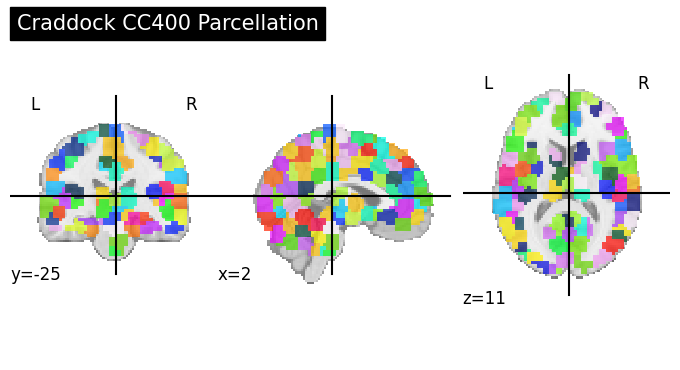

In [245]:
from nilearn import datasets
from nilearn.image import load_img
from nilearn.plotting import find_parcellation_cut_coords
from nilearn import plotting

atlas_filename = "cc400_roi_atlas.nii.gz"
atlas_img = load_img(atlas_filename)
coords = find_parcellation_cut_coords(atlas_img)


# print(coords)
# # Visualize the parcellation
plotting.plot_roi(atlas_filename, title="Craddock CC400 Parcellation")


# # Plot connectome
# plotting.plot_connectome(correlation_matrix, coords, edge_threshold="99%")


## Loading Data

In [246]:
# data = np.loadtxt("Caltech_0051456_rois_cc400.1D") # WAS GIVEN ME NANS!
data = np.loadtxt("Leuven_2_0050733_rois_cc400.1D") 


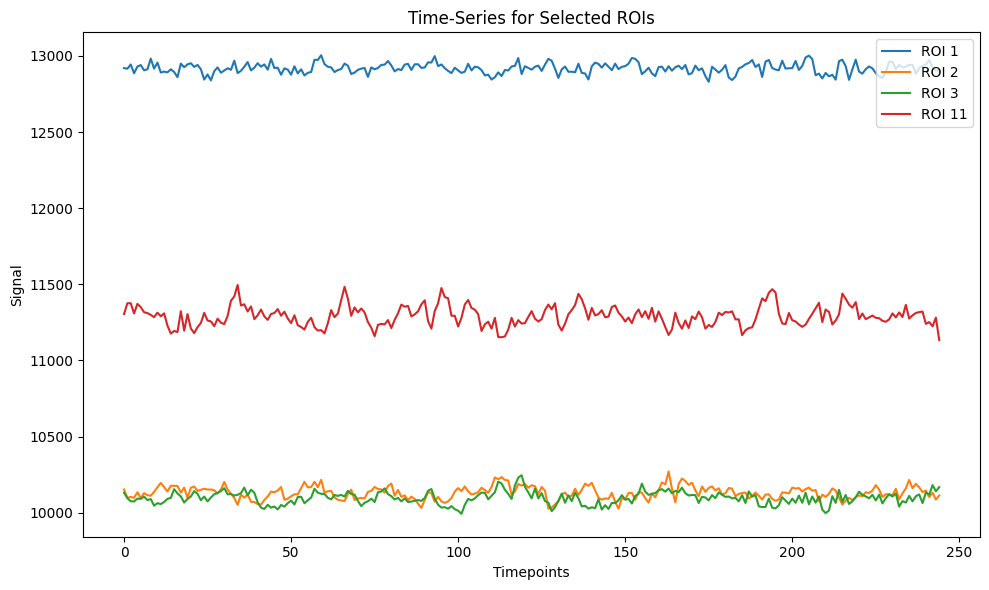

In [247]:
# Specify the ROIs you want to plot
selected_rois = [0, 1, 2, 10]  # Example: plot ROIs 1, 2, 3, and 11

plt.figure(figsize=(10, 6))

for i in selected_rois:
    plt.plot(data[:, i], label=f'ROI {i+1}')  # Plot each selected ROI's time-series

plt.xlabel("Timepoints")
plt.ylabel("Signal")
plt.title("Time-Series for Selected ROIs")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [248]:
# Calculation of pearsons coefficient
correlation_matrix = np.corrcoef(data.T) #transposed to get proper shape

num_regions = correlation_matrix.shape[0]

# Set diagonal to 0 (remove self-loops)
np.fill_diagonal(correlation_matrix, 0)

print(f"Num regions: {num_regions}")

print(correlation_matrix)

Num regions: 392
[[ 0.         -0.15985549  0.03958378 ...  0.05958874  0.21952563
  -0.10794976]
 [-0.15985549  0.          0.35313345 ...  0.03477268 -0.02140933
   0.61501267]
 [ 0.03958378  0.35313345  0.         ...  0.22784352  0.024608
   0.18106225]
 ...
 [ 0.05958874  0.03477268  0.22784352 ...  0.          0.36485827
  -0.21623293]
 [ 0.21952563 -0.02140933  0.024608   ...  0.36485827  0.
  -0.12824031]
 [-0.10794976  0.61501267  0.18106225 ... -0.21623293 -0.12824031
   0.        ]]


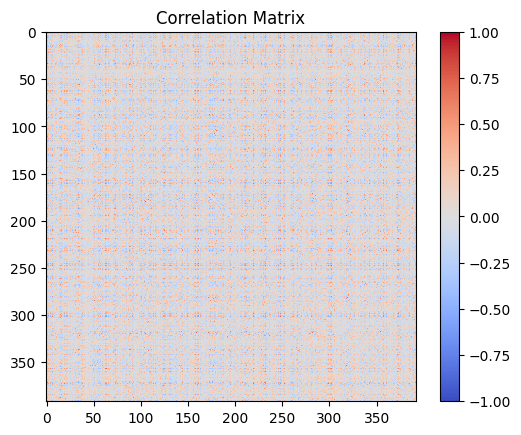

Min correlation: -0.7794961130095838
Max correlation: 0.9393363283897674
Mean correlation: 0.011549365109988231


In [249]:
import matplotlib.pyplot as plt

# Visualize the correlation matrix
plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title("Correlation Matrix")
plt.show()

# Check basic statistics
print(f"Min correlation: {np.min(correlation_matrix)}")
print(f"Max correlation: {np.max(correlation_matrix)}")
print(f"Mean correlation: {np.mean(correlation_matrix)}")

# Makes sense that we have a max of 1, we are correlating with itself!

# get rid of self-correlation


## Thresholding

In [250]:
# # 1) Fixed Threshold
# '''
# The fixed threshold approach requires selecting a single threshold according to one of three criteria: (1) using a specified significance level (e.g., α = 0.05) 
# to retain “significant” connections (with a correction for multiple comparisons); (2) employing a uniform threshold across all networks (e.g., ρ̂ > 0.5); 
# (3) defining a threshold that minimizes the number of connections while ensuring all nodes are connected to the main component. The major limitation of this fixed threshold 
# approach is that the generated networks generally vary in average degree k (average number of connections) which can confound subsequent comparative analyses
# '''


# p_values = np.ones((num_regions, num_regions))

# # calculate baseline p-values for each pair of correlations
# for i in range(num_regions):
#     for j in range(i + 1, num_regions):
#         corr_val = correlation_matrix[i, j]
#         _, p_value = pearsonr(correlation_matrix[i], correlation_matrix[j])
#         p_values[i, j] = p_value
#         p_values[j, i] = p_value

# alpha = 0.05
# _, corrected_p_values, _, _ = multipletests(p_values.flatten(), alpha=alpha, method='fdr_bh')
# corrected_p_values = corrected_p_values.reshape(num_regions, num_regions)


In [251]:
# # FIXED THRESHOLDING
# # (1)
# adj_matrix_sig = (corrected_p_values < alpha).astype(int)

# # (2)
# rho_threshold = 0.01
# adj_matrix_rho = (correlation_matrix > rho_threshold).astype(int)

# # (3)
# # TODO

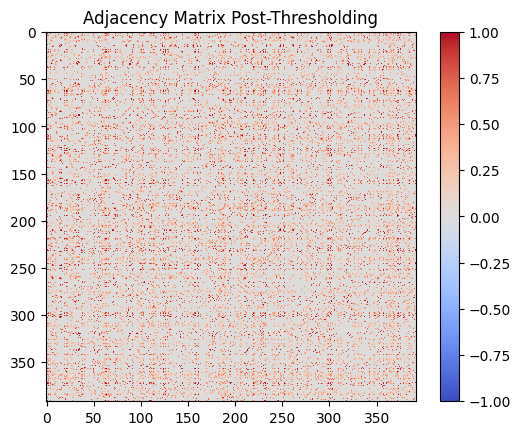

In [252]:
# abs_corr_matrix = np.abs(correlation_matrix)
# abs_corr_matrix = correlation_matrix

# Rho thresholding
rho_threshold = 0.3

# Retain positive correlations above +rho

# adj_matrix_rho = np.zeros(correlation_matrix.shape, dtype=int)

# adj_matrix_rho[correlation_matrix > rho_threshold] = 1

# # Retain negative correlations below -rho
# adj_matrix_rho[correlation_matrix < -rho_threshold] = 1

adj_matrix_rho = (correlation_matrix > rho_threshold).astype(float)

# Visualize the correlation matrix
plt.imshow(adj_matrix_rho, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title("Adjacency Matrix Post-Thresholding")
plt.show()

__Percentage Based Thresholding__

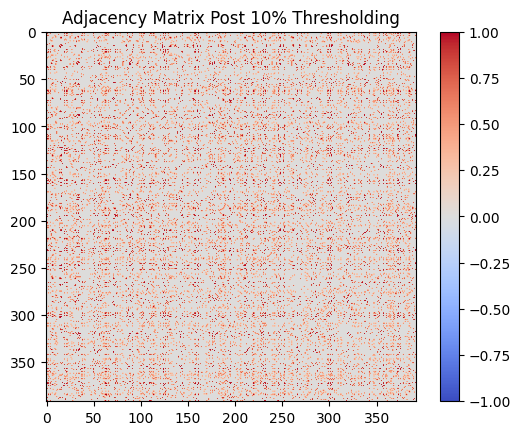

In [253]:
# Define the desired percentage of values to retain
percentage_to_keep = 0.10  # e.g., keep the top x% of connections

# Step 2: Flatten the matrix and sort the absolute values in descending order
sorted_abs_values = np.sort(correlation_matrix.flatten())[::-1]

# Step 3: Determine the threshold value based on the percentage
num_elements_to_keep = int(len(sorted_abs_values) * percentage_to_keep)
threshold_value = sorted_abs_values[num_elements_to_keep - 1]

# Step 4: Create a new adjacency matrix based on this threshold
adj_matrix_percentage = np.zeros(correlation_matrix.shape, dtype=int)
adj_matrix_percentage[correlation_matrix >= threshold_value] = 1

# Visualize the adjacency matrix after percentage-based thresholding
plt.imshow(adj_matrix_percentage, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title(f"Adjacency Matrix Post {int(percentage_to_keep*100)}% Thresholding")
plt.show()

In [254]:
# # MST
# # Minimum spanning tree
# from scipy.sparse.csgraph import minimum_spanning_tree

# mst_matrix = minimum_spanning_tree(abs_corr_matrix).toarray()

# # Combine MST edges (ensures connectivity) and thresholded edges
# combined_adj_matrix = np.maximum(mst_matrix, adj_matrix_rho)


In [255]:
G = nx.from_numpy_array(adj_matrix_percentage)
# Check if the graph is connected
print("Is the graph connected?", nx.is_connected(G))

avg_clustering = nx.average_clustering(G)
avg_shortest_path_length = nx.average_shortest_path_length(G)
print(f"Average Clustering: {avg_clustering}")
print(f"Average Shortest Path: {avg_shortest_path_length}")
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Now you can compute network metrics, etc.
degree_centrality = nx.degree_centrality(G)

# print(f"Degree Centrality: {degree_centrality}")

# Average degree
degrees = [G.degree(node) for node in G]
print(min(degrees), max(degrees))

print(f"numpy Mean Degree: {np.mean(degrees)}")


Is the graph connected? True
Average Clustering: 0.49316898925364605
Average Shortest Path: 2.4028654940236964
Graph has 392 nodes and 7683 edges.
3 98
numpy Mean Degree: 39.19897959183673


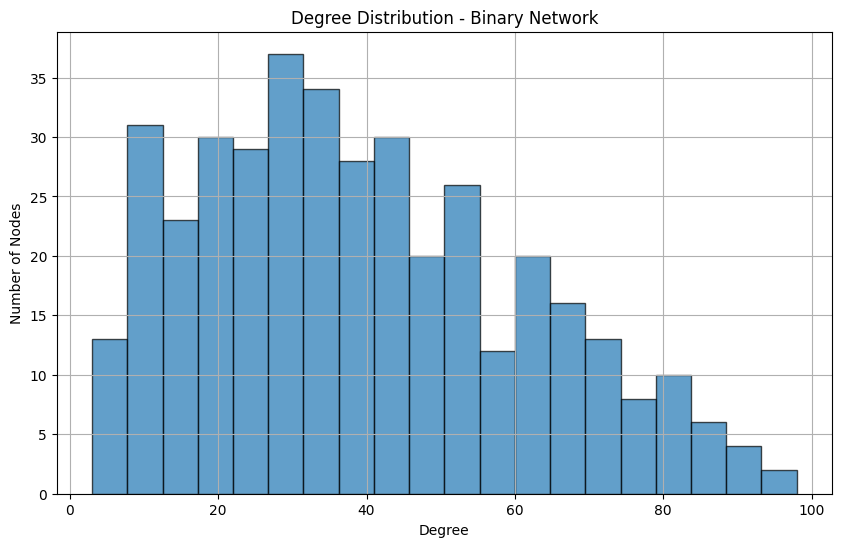

In [256]:
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=20, edgecolor='black', alpha=0.7)
plt.title('Degree Distribution - Binary Network')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.grid(True)
plt.show()

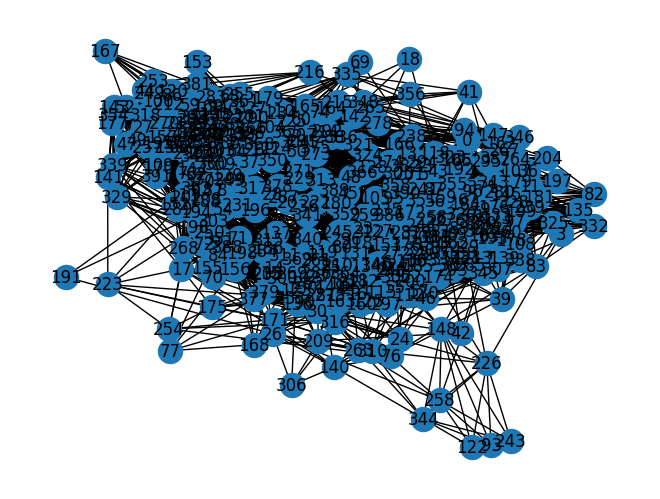

In [257]:
# Optional: Visualize the graph
edges = G.edges(data=True)
nx.draw(G, with_labels=True, edge_cmap=plt.cm.Blues)
plt.show()

In [258]:
# Attempting to output to Brain Net Viewer
node_data = pd.DataFrame(index=range(len(G.nodes)))  # Example placeholder for node data
output_brain_net_viewer(node_data, G, coords, 'output_binary.node', 'output_binary.edge')

edge_matrix = nx.to_numpy_array(G, weight='weight')
np.savetxt('output_binary.edge', edge_matrix)


## Weighted Representation

In [259]:
weighted_adj_matrix = correlation_matrix.copy()

weighted_adj_matrix = np.abs(correlation_matrix)

threshold = 0.1  # Set a small threshold to remove weak connections
weighted_adj_matrix = np.where(np.abs(correlation_matrix) > threshold, correlation_matrix, 0)

weighted_adj_matrix = 1 - np.abs(correlation_matrix)  # Treat stronger correlations as shorter distances


# Set diagonal to 0 (remove self-loops)
np.fill_diagonal(weighted_adj_matrix, 0)

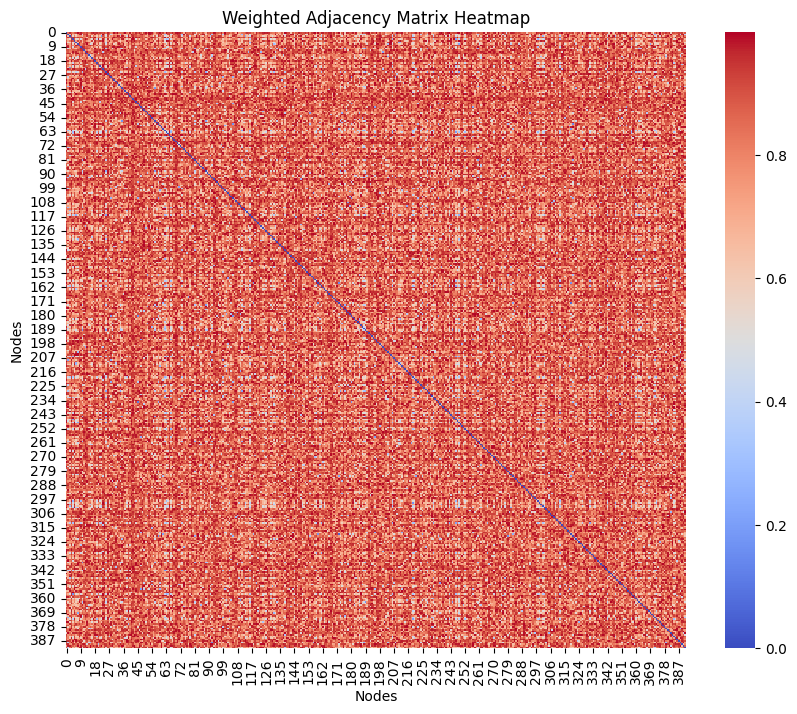

In [260]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming weighted_adj_matrix is your matrix
plt.figure(figsize=(10, 8))
sns.heatmap(weighted_adj_matrix, cmap="coolwarm", annot=False, cbar=True)

plt.title("Weighted Adjacency Matrix Heatmap")
plt.xlabel("Nodes")
plt.ylabel("Nodes")
plt.show()

In [261]:
G = nx.from_numpy_array(weighted_adj_matrix)
# Check if the graph is connected
print("Is the graph connected?", nx.is_connected(G))


# Add weights to the graph edges
for i, j in zip(*np.where(weighted_adj_matrix != 0)):
    G[i][j]['weight'] = weighted_adj_matrix[i, j]

avg_clustering = nx.average_clustering(G, weight='weight')
avg_shortest_path_length = nx.average_shortest_path_length(G, weight='weight')
print(f"Average Clustering: {avg_clustering}")
print(f"Average Shortest Path: {avg_shortest_path_length}")
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Now you can compute network metrics, etc.
degree_centrality = nx.degree_centrality(G)

# Average degree
degrees = [G.degree(node, weight='weight') for node in G]
print(min(degrees), max(degrees))

print(f"numpy Mean Degree: {np.mean(degrees)}")


Is the graph connected? True
Average Clustering: 0.8260134436462925
Average Shortest Path: 0.8327393384944111
Graph has 392 nodes and 76636 edges.
282.9111778467273 359.36786197938744
numpy Mean Degree: 326.02713893020075


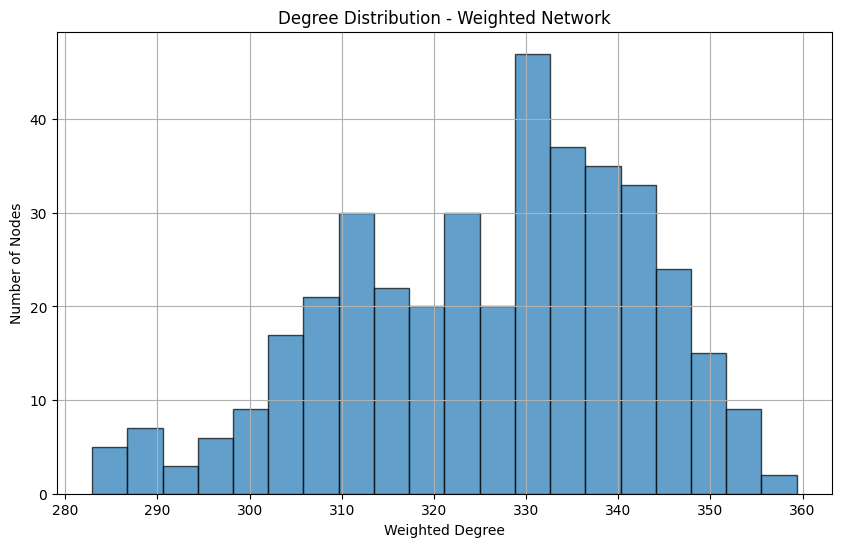

In [262]:
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=20, edgecolor='black', alpha=0.7)
plt.title('Degree Distribution - Weighted Network')
plt.xlabel('Weighted Degree')
plt.ylabel('Number of Nodes')
plt.grid(True)
plt.show()

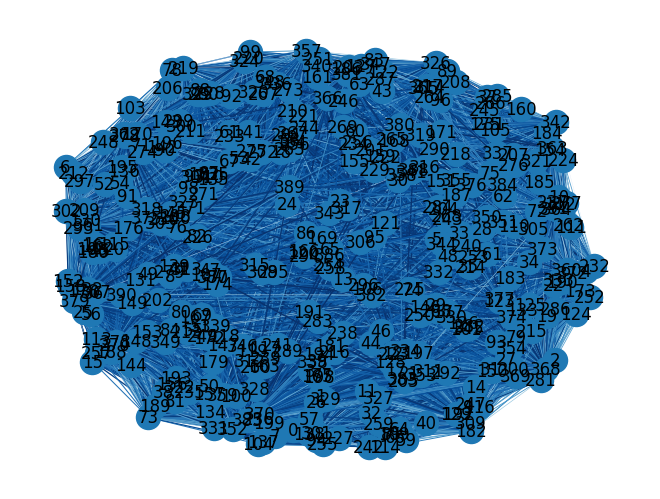

In [263]:
# Optional: Visualize the graph
edges = G.edges(data=True)
weights = [d['weight'] for (u, v, d) in edges]
nx.draw(G, with_labels=True, edge_color=weights, edge_cmap=plt.cm.Blues, width=weights)
plt.show()

In [264]:
# Attempting to output to Brain Net Viewer
node_data = pd.DataFrame(index=range(len(G.nodes)))  # Example placeholder for node data
output_brain_net_viewer(node_data, G, coords, 'output_weighted.node', 'output_weighted.edge', weighted=True)

edge_matrix = nx.to_numpy_array(G, weight='weight')
np.savetxt('output_weighted.edge', edge_matrix)
